## FIR_and_IIR_Filter_Design

In [1]:
%pylab inline
import sk_dsp_comm.sigsys as ss
import sk_dsp_comm.fir_design_helper as fir_d
import sk_dsp_comm.iir_design_helper as iir_d
import sk_dsp_comm.multirate_helper as mrh
import scipy.signal as signal
from IPython.display import Audio, display
from IPython.display import Image, SVG

Populating the interactive namespace from numpy and matplotlib


In [2]:
%config InlineBackend.figure_formats=['svg'] # SVG inline viewing

In [2]:
# Helper imports
import sk_dsp_comm.fir_design_helper as fir_d
import sk_dsp_comm.iir_design_helper as iir_d

# Design From Amplitude Response Requirements

With both `fir_design_helper` and `iir_design_helper` a design starts with amplitude response requirements, that is the filter passband critical frequencies, stopband critical frequencies, passband ripple, and stopband attenuation. The number of taps/coefficients (FIR case) or the filter order (IIR case) needed to meet these requirements is then determined and the filter coefficients are returned as an ndarray b for FIR, and for IIR both b and a arrays, and a second-order sections sos 2D array, with the rows containing the corresponding cascade of second-order sections toplogy for IIR filters.

For the FIR case we have in the $z$-domain $$H_\text{FIR}(z) = \sum_{k=0}^N b_k z^{-k}$$

with ndarray b = $[b_0, b_1, \ldots, b_N]$. 

For the IIR case we have in the $z$-domain
$$\[\begin{split}\begin{align} H_\text{IIR}(z) &= \frac{\sum_{k=0}^M b_k z^{-k}}{\sum_{k=1}^N a_k z^{-k}} \\ &= \prod_{k=0}^{N_s-1} \frac{b_{k0} + b_{k1} z^{-1} + b_{k2} z^{-2}}{1 + a_{k1} z^{-1} + a_{k2} z^{-2}} = \prod_{k=0}^{N_s-1} H_k(z) \end{align}\end{split}\]$$
where \(N_s = \lfloor(N+1)/2\rfloor\). For the b/a form the coefficients are arranged as
```bash
    b = [b0, b1, ..., bM-1], the numerator filter coefficients
    a = [a0, a1, ..., aN-1], the denominator filter ceofficients
```
For the sos form each row of the 2D sos array corresponds to the coefficients of $H_k(z)$, as follows:
```bash
    SOS_mat = [[b00, b01, b02, 1, a01, a02], #biquad 0
               [b10, b11, b12, 1, a11, a12], #biquad 1
                .
                .
               [bNs-10, bNs-11, bNs-12, 1, aNs-11, aNs-12]] #biquad Ns-1
```

# Linear Phase FIR Filter Design


The primary focus of this module is adding the ability to design linear phase FIR filters from user friendly amplitude response requirements.


Most digital filter design is motivated by the desire to approach an ideal filter. Recall an ideal filter will pass signals of a certain of frequencies and block others. For both analog and digital filters the designer can choose from a variety of approximation techniques. For digital filters the approximation techniques fall into the categories of IIR or FIR. In the design of FIR filters two popular techniques are truncating the ideal filter impulse response and applying a window, and optimum equiripple approximations [Oppenheim2010](https://www.amazon.com/Discrete-Time-Signal-Processing-3rd-Prentice-Hall/dp/0131988425/ref=sr_1_1?ie=UTF8&qid=1519940790&sr=8-1&keywords=oppenheim+discrete+time+signal+processing&dpID=51v48p99JjL&preST=_SX218_BO1,204,203,200_QL40_&dpSrc=srch). Frequency sampling based approaches are also popular, but will not be considered here, even though scipy.signal supports all three. Filter design generally begins with a specification of the desired frequency response. The filter frequency response may be stated in several ways, but amplitude response is the most common, e.g., state how $H_c(j\Omega)$ or $H(e^{j\omega}) = H(e^{j2\pi f/f_s})$ should behave. A completed design consists of the number of coefficients (taps) required and the coefficients themselves (double precision float or float64 in Numpy, and float64_t in C). Figure 1, below, shows amplitude response requirements in terms of filter gain and critical frequencies for lowpass, highpass, bandpass, and bandstop filters. The critical frequencies are given here in terms of analog requirements in Hz. The sampling frequency is assumed to be in Hz. The passband ripple and stopband attenuation values are in dB. Note in dB terms attenuation is the negative of gain, e.g., -60 of stopband gain is equivalent to 60 dB of stopband attenuation.

![Image](https://github.com/mwickert/scikit-dsp-comm/raw/master/docs/source/nb_examples/300ppi/FIR_Lowpass_Highpass_Bandpass_Bandstop%40300ppi.png)

There are 10 filter design functions and one plotting function available in `fir_design_helper.py`. Four functions for designing Kaiser window based FIR filters and four functions for designing equiripple based FIR filters. Of the eight just described, they all take in amplitude response requirements and return a coefficients array. Two of the 10 filter functions are simply wrappers around the `scipy.signal` function `signal.firwin()` for designing filters of a specific order when one (lowpass) or two (bandpass) critical frequencies are given. The wrapper functions fix the window type to the firwin default of hann (hanning). The remamining eight are described below in Table 1. The plotting function provides an easy means to compare the resulting frequency response of one or more designs on a single plot. Display modes allow gain in dB, phase in radians, group delay in samples, and group delay in seconds for a given sampling rate. This function, `freq_resp_list()`, works for both FIR and IIR designs. Table 1 provides the interface details to the eight design functions where d_stop and d_pass are positive dB values and the critical frequencies have the same unit as the sampling frequency $f_s$. These functions do not create perfect results so some tuning of of the design parameters may be needed, in addition to bumping the filter order up or down via `N_bump`.

![Image](https://github.com/mwickert/scikit-dsp-comm/raw/master/docs/source/nb_examples/300ppi/FIR_Kaiser_Equiripple_Table%40300ppi.png)

# Design Examples

### Example 1: Lowpass with $f_s = 1$ Hz
For this 31 tap filter we choose the cutoff frequency to be $F_c = F_s/8$, or in normalized form $f_c = 1/8$.

In [3]:
b_k = fir_d.firwin_kaiser_lpf(1/8,1/6,50,1.0)
b_r = fir_d.fir_remez_lpf(1/8,1/6,0.2,50,1.0)

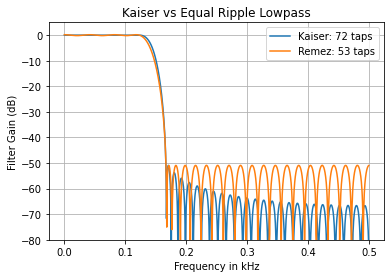

In [4]:
fir_d.freqz_resp_list([b_k,b_r],[[1],[1]],'dB',fs=1)
ylim([-80,5])
title(r'Kaiser vs Equal Ripple Lowpass')
ylabel(r'Filter Gain (dB)')
xlabel(r'Frequency in kHz')
legend((r'Kaiser: %d taps' % len(b_k),r'Remez: %d taps' % len(b_r)),loc='best')
grid();

In [5]:
b_k_hp = fir_d.firwin_kaiser_hpf(1/8,1/6,50,1.0)
b_r_hp = fir_d.fir_remez_hpf(1/8,1/6,0.2,50,1.0)

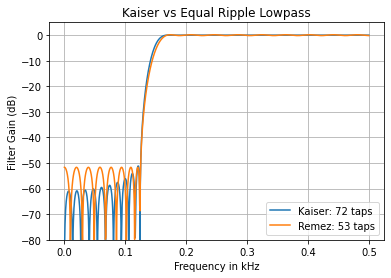

In [6]:
fir_d.freqz_resp_list([b_k_hp,b_r_hp],[[1],[1]],'dB',fs=1)
ylim([-80,5])
title(r'Kaiser vs Equal Ripple Lowpass')
ylabel(r'Filter Gain (dB)')
xlabel(r'Frequency in kHz')
legend((r'Kaiser: %d taps' % len(b_k),r'Remez: %d taps' % len(b_r)),loc='best')
grid();

In [7]:
b_k_bp = fir_d.firwin_kaiser_bpf(7000,8000,14000,15000,50,48000)
b_r_bp = fir_d.fir_remez_bpf(7000,8000,14000,15000,0.2,50,48000)

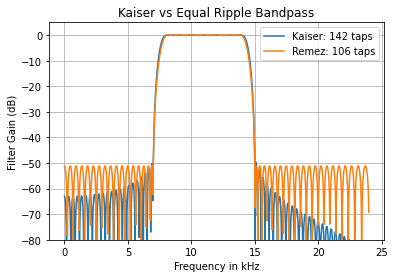

In [8]:
fir_d.freqz_resp_list([b_k_bp,b_r_bp],[[1],[1]],'dB',fs=48)
ylim([-80,5])
title(r'Kaiser vs Equal Ripple Bandpass')
ylabel(r'Filter Gain (dB)')
xlabel(r'Frequency in kHz')
legend((r'Kaiser: %d taps' % len(b_k_bp),
        r'Remez: %d taps' % len(b_r_bp)),
       loc='upper right')
grid();

# A Design Example Useful for Interpolation or Decimation

Here we consider a lowpass design that needs to pass frequencies from [0, 4000] Hz with a sampling rate of 96000 Hz. This scenario arises when building an interpolator using the classes of the `scikit-dps-comm` module `multirate_helper.py` to increase the sampling rate from 8000 Hz to 96000 Hz, or an interpolation factor of $L = 12$. Note at the top of this notebook we have also have the import
```
import sk_dsp_comm.multirate_helper as mrh
```
so that some of the functionality can be accessed. For more details on the use of `multirate_helper` see.

Start with an equalripple design having transition band centered on 4000 Hz with passband ripple of 0.5 dB and stopband attenuation of 60 dB.

In [9]:
b_up = fir_d.fir_remez_lpf(3300,4300,0.5,60,96000)

In [10]:
mr_up = mrh.multirate_FIR(b_up)

- Consider the pole-zero configuration for this high-order filter

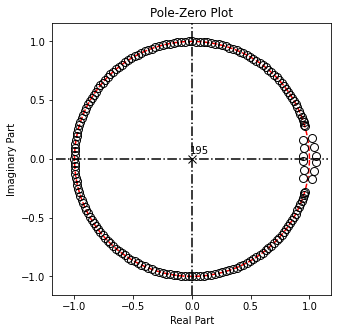

In [11]:
# Take a look at the pole-zero configuration of this very
# high-order (many taps) linear phase FIR
mr_up.zplane()

- Check out the passband and stopband gains

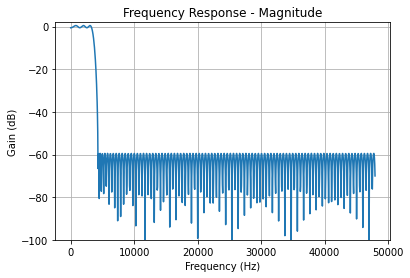

In [12]:
# Verify the passband and stopband gains are as expected
mr_up.freq_resp('db',96000)

- See that the group delay is the expected value of $(N_\text{taps} - 1)/2 = 98$ samples

In [13]:
(len(b_up-1))/2

98.0

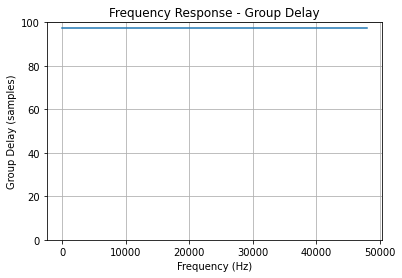

In [14]:
# Verify that the FIR design has constant group delay (N_taps - 1)/2 samples
mr_up.freq_resp('groupdelay_s',96000,[0,100])

The object mr_up can now be used for interpolation or decimation with a rate change factor of 12.

## Reference
1. **Mark Wickert, ["FIR_and_IIR_Filter_Design"](https://scikit-dsp-comm.readthedocs.io/en/latest/nb_examples/FIR_and_IIR_Filter_Design.html).**